## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
import helper_utils
import torch.nn.functional as F
from pprint import pprint

helper_utils.set_seed(15)

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class FlexibleCNN(nn.Module):
    """
    A flexible Convolutional Neural Network with a dynamically created classifier.

    This CNN's architecture is defined by the provided hyperparameters,
    allowing for a variable number of convolutional layers. The classifier
    (fully connected layers) is constructed during the first forward pass
    to adapt to the output size of the convolutional feature extractor.
    """
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout_rate, fc_size):
        """
        Initializes the feature extraction part of the CNN.

        Args:
            n_layers: The number of convolutional blocks to create.
            n_filters: A list of integers specifying the number of output
                       filters for each convolutional block.
            kernel_sizes: A list of integers specifying the kernel size for
                          each convolutional layer.
            dropout_rate: The dropout probability to be used in the classifier.
            fc_size: The number of neurons in the hidden fully connected layer.
        """
        super(FlexibleCNN, self).__init__()

        # Initialize an empty list to hold the convolutional blocks
        blocks = []
        # Set the initial number of input channels for RGB images
        in_channels = 3

        # Loop to construct each convolutional block
        for i in range(n_layers):

            # Get the parameters for the current convolutional layer
            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]
            # Calculate padding to maintain the input spatial dimensions ('same' padding)
            padding = (kernel_size - 1) // 2

            # Define a block as a sequence of Conv, ReLU, and MaxPool layers
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            
            # Add the newly created block to the list
            blocks.append(block)

            # Update the number of input channels for the next block
            in_channels = out_channels

        # Combine all blocks into a single feature extractor module
        self.features = nn.Sequential(*blocks)

        # Store hyperparameters needed for building the classifier later
        self.dropout_rate = dropout_rate
        self.fc_size = fc_size

        # The classifier will be initialized dynamically in the forward pass
        self.classifier = None

    def _create_classifier(self, flattened_size, device):
        """
        Dynamically creates and initializes the classifier part of the network.

        This helper method is called during the first forward pass to build the
        fully connected layers based on the feature map size from the
        convolutional base.

        Args:
            flattened_size: The number of input features for the first linear
                            layer, determined from the flattened feature map.
            device: The device to which the new classifier layers should be moved.
        """
        # Define the classifier's architecture
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.fc_size, 10)  # Assumes 10 output classes (e.g., CIFAR-10)
        ).to(device)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: The input tensor of shape (batch_size, channels, height, width).

        Returns:
            The output logits from the classifier.
        """
        # Get the device of the input tensor to ensure consistency
        device = x.device

        # Pass the input through the feature extraction layers
        x = self.features(x)

        # Flatten the feature map to prepare it for the fully connected layers
        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        # If the classifier has not been created yet, initialize it
        if self.classifier is None:
            self._create_classifier(flattened_size, device)

        # Pass the flattened features through the classifier to get the final output
        return self.classifier(flattened)

In [4]:
def objective(trial, device):
    """
    Defines the objective function for hyperparameter optimization using Optuna.

    For each trial, this function samples a set of hyperparameters,
    constructs a model, trains it for a fixed number of epochs, evaluates
    its performance on a validation set, and returns the accuracy. Optuna
    uses the returned accuracy to guide its search for the best
    hyperparameter combination.

    Args:
        trial: An Optuna `Trial` object, used to sample hyperparameters.
        device: The device ('cpu' or 'cuda') for model training and evaluation.

    Returns:
        The validation accuracy of the trained model as a float.
    """
    # Sample hyperparameters for the feature extractor using the Optuna trial
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_filters = [trial.suggest_int(f"n_filters_{i}", 16, 128) for i in range(n_layers)]
    kernel_sizes = [trial.suggest_categorical(f"kernel_size_{i}", [3, 5]) for i in range(n_layers)]

    # Sample hyperparameters for the classifier
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    fc_size = trial.suggest_int("fc_size", 64, 256)

    # Instantiate the model with the sampled hyperparameters
    model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout_rate, fc_size).to(device)

    # Define fixed training parameters: learning rate, loss function, and optimizer
    learning_rate = 0.001
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define fixed data loading parameters and create data loaders
    batch_size = 128
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

    # Define the fixed number of epochs for training
    n_epochs = 10
    # Train the model using a helper function
    helper_utils.train_model(
        model=model,
        optimizer=optimizer,
        train_dataloader=train_loader,
        n_epochs=n_epochs,
        loss_fcn=loss_fcn,
        device=device
    )

    # Evaluate the trained model's accuracy on the validation set
    accuracy = helper_utils.evaluate_accuracy(model, val_loader, device)
    
    # Return the final accuracy for this trial
    return accuracy

In [5]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize') # The goal in this case is to maximize accuracy

# Start the optimization process (it takes about 8 minutes for 20 trials)
n_trials = 20
study.optimize(lambda trial: objective(trial, device), n_trials=n_trials) # use more trials in practice

[I 2025-12-03 22:04:20,890] A new study created in memory with name: no-name-f18c45d1-5772-48f3-ba74-0a901d6d208f


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2729
Epoch 10 - Train Loss: 2.2534
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:04:38,077] Trial 0 finished with value: 0.2185 and parameters: {'n_layers': 1, 'n_filters_0': 46, 'kernel_size_0': 3, 'dropout_rate': 0.44888075409246453, 'fc_size': 183}. Best is trial 0 with value: 0.2185.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.1828
Epoch 10 - Train Loss: 2.1255
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:04:55,893] Trial 1 finished with value: 0.2725 and parameters: {'n_layers': 1, 'n_filters_0': 60, 'kernel_size_0': 5, 'dropout_rate': 0.14766209974853634, 'fc_size': 145}. Best is trial 1 with value: 0.2725.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2593
Epoch 10 - Train Loss: 2.2336
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:05:12,611] Trial 2 finished with value: 0.2215 and parameters: {'n_layers': 1, 'n_filters_0': 51, 'kernel_size_0': 3, 'dropout_rate': 0.29146692989906775, 'fc_size': 114}. Best is trial 1 with value: 0.2725.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2683
Epoch 10 - Train Loss: 2.2489
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:05:27,883] Trial 3 finished with value: 0.2295 and parameters: {'n_layers': 1, 'n_filters_0': 21, 'kernel_size_0': 5, 'dropout_rate': 0.3676524379930225, 'fc_size': 160}. Best is trial 1 with value: 0.2725.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2492
Epoch 10 - Train Loss: 2.2282
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:05:45,035] Trial 4 finished with value: 0.215 and parameters: {'n_layers': 1, 'n_filters_0': 48, 'kernel_size_0': 3, 'dropout_rate': 0.21756723973896042, 'fc_size': 243}. Best is trial 1 with value: 0.2725.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.8781
Epoch 10 - Train Loss: 1.7127
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:06:05,400] Trial 5 finished with value: 0.48 and parameters: {'n_layers': 3, 'n_filters_0': 56, 'n_filters_1': 47, 'n_filters_2': 79, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 3, 'dropout_rate': 0.29080572066296373, 'fc_size': 156}. Best is trial 5 with value: 0.48.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.1822
Epoch 10 - Train Loss: 2.1249
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:06:25,164] Trial 6 finished with value: 0.334 and parameters: {'n_layers': 2, 'n_filters_0': 96, 'n_filters_1': 57, 'kernel_size_0': 3, 'kernel_size_1': 3, 'dropout_rate': 0.4584791041961288, 'fc_size': 179}. Best is trial 5 with value: 0.48.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.1873
Epoch 10 - Train Loss: 2.0775
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:06:47,245] Trial 7 finished with value: 0.3575 and parameters: {'n_layers': 3, 'n_filters_0': 54, 'n_filters_1': 121, 'n_filters_2': 27, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 3, 'dropout_rate': 0.49540126944128915, 'fc_size': 67}. Best is trial 5 with value: 0.48.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2634
Epoch 10 - Train Loss: 2.2396
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:07:06,502] Trial 8 finished with value: 0.245 and parameters: {'n_layers': 1, 'n_filters_0': 84, 'kernel_size_0': 3, 'dropout_rate': 0.4216763339777164, 'fc_size': 248}. Best is trial 5 with value: 0.48.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6374
Epoch 10 - Train Loss: 1.3771
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:07:40,864] Trial 9 finished with value: 0.542 and parameters: {'n_layers': 3, 'n_filters_0': 68, 'n_filters_1': 116, 'n_filters_2': 40, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.22581928835008452, 'fc_size': 112}. Best is trial 9 with value: 0.542.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5550
Epoch 10 - Train Loss: 1.3577
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:08:15,631] Trial 10 finished with value: 0.522 and parameters: {'n_layers': 2, 'n_filters_0': 121, 'n_filters_1': 123, 'kernel_size_0': 5, 'kernel_size_1': 5, 'dropout_rate': 0.11202779228748073, 'fc_size': 66}. Best is trial 9 with value: 0.542.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5835
Epoch 10 - Train Loss: 1.3719
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:08:51,605] Trial 11 finished with value: 0.4985 and parameters: {'n_layers': 2, 'n_filters_0': 126, 'n_filters_1': 126, 'kernel_size_0': 5, 'kernel_size_1': 5, 'dropout_rate': 0.12018876157123581, 'fc_size': 69}. Best is trial 9 with value: 0.542.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.7267
Epoch 10 - Train Loss: 1.4738
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:09:24,724] Trial 12 finished with value: 0.4965 and parameters: {'n_layers': 3, 'n_filters_0': 111, 'n_filters_1': 94, 'n_filters_2': 22, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.1976922910947761, 'fc_size': 105}. Best is trial 9 with value: 0.542.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.7711
Epoch 10 - Train Loss: 1.6072
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:09:50,985] Trial 13 finished with value: 0.477 and parameters: {'n_layers': 2, 'n_filters_0': 82, 'n_filters_1': 93, 'kernel_size_0': 5, 'kernel_size_1': 5, 'dropout_rate': 0.200000162588427, 'fc_size': 100}. Best is trial 9 with value: 0.542.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.4681
Epoch 10 - Train Loss: 1.2134
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:10:17,060] Trial 14 finished with value: 0.5445 and parameters: {'n_layers': 3, 'n_filters_0': 111, 'n_filters_1': 16, 'n_filters_2': 124, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.10835993203912958, 'fc_size': 126}. Best is trial 14 with value: 0.5445.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5963
Epoch 10 - Train Loss: 1.3881
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:10:39,892] Trial 15 finished with value: 0.519 and parameters: {'n_layers': 3, 'n_filters_0': 96, 'n_filters_1': 18, 'n_filters_2': 126, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.24558716222457758, 'fc_size': 115}. Best is trial 14 with value: 0.5445.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6355
Epoch 10 - Train Loss: 1.4347
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:11:05,203] Trial 16 finished with value: 0.5005 and parameters: {'n_layers': 3, 'n_filters_0': 72, 'n_filters_1': 16, 'n_filters_2': 70, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.16185128406254734, 'fc_size': 133}. Best is trial 14 with value: 0.5445.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6767
Epoch 10 - Train Loss: 1.4541
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:11:30,764] Trial 17 finished with value: 0.548 and parameters: {'n_layers': 3, 'n_filters_0': 28, 'n_filters_1': 89, 'n_filters_2': 121, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.3537377617421017, 'fc_size': 213}. Best is trial 17 with value: 0.548.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6436
Epoch 10 - Train Loss: 1.4339
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:11:54,979] Trial 18 finished with value: 0.529 and parameters: {'n_layers': 3, 'n_filters_0': 22, 'n_filters_1': 76, 'n_filters_2': 127, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.3713580656296326, 'fc_size': 214}. Best is trial 17 with value: 0.548.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.0380
Epoch 10 - Train Loss: 1.9558
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-03 22:12:14,412] Trial 19 finished with value: 0.404 and parameters: {'n_layers': 2, 'n_filters_0': 35, 'n_filters_1': 38, 'kernel_size_0': 5, 'kernel_size_1': 5, 'dropout_rate': 0.3590886195042673, 'fc_size': 212}. Best is trial 17 with value: 0.548.


Evaluation complete.


In [6]:
# Extract the dataframe with the results
df = study.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate,params_fc_size,params_kernel_size_0,params_kernel_size_1,params_kernel_size_2,params_n_filters_0,params_n_filters_1,params_n_filters_2,params_n_layers,state
0,0,0.2185,2025-12-03 22:04:20.891391,2025-12-03 22:04:38.077480,0 days 00:00:17.186089,0.448881,183,3,NaN,NaN,46,NaN,NaN,1,COMPLETE
1,1,0.2725,2025-12-03 22:04:38.077986,2025-12-03 22:04:55.893042,0 days 00:00:17.815056,0.147662,145,5,NaN,NaN,60,NaN,NaN,1,COMPLETE
2,2,0.2215,2025-12-03 22:04:55.893584,2025-12-03 22:05:12.611342,0 days 00:00:16.717758,0.291467,114,3,NaN,NaN,51,NaN,NaN,1,COMPLETE
3,3,0.2295,2025-12-03 22:05:12.611974,2025-12-03 22:05:27.883910,0 days 00:00:15.271936,0.367652,160,5,NaN,NaN,21,NaN,NaN,1,COMPLETE
4,4,0.2150,2025-12-03 22:05:27.884449,2025-12-03 22:05:45.035097,0 days 00:00:17.150648,0.217567,243,3,NaN,NaN,48,NaN,NaN,1,COMPLETE
5,5,0.4800,2025-12-03 22:05:45.035732,2025-12-03 22:06:05.399956,0 days 00:00:20.364224,0.290806,156,3,3.0,3.0,56,47.0,79.0,3,COMPLETE
6,6,0.3340,2025-12-03 22:06:05.400592,2025-12-03 22:06:25.164923,0 days 00:00:19.764331,0.458479,179,3,3.0,NaN,96,57.0,NaN,2,COMPLETE
7,7,0.3575,2025-12-03 22:06:25.165369,2025-12-03 22:06:47.245061,0 days 00:00:22.079692,0.495401,67,3,3.0,3.0,54,121.0,27.0,3,COMPLETE
8,8,0.2450,2025-12-03 22:06:47.245496,2025-12-03 22:07:06.502186,0 days 00:00:19.256690,0.421676,248,3,NaN,NaN,84,NaN,NaN,1,COMPLETE
9,9,0.5420,2025-12-03 22:07:06.502649,2025-12-03 22:07:40.863936,0 days 00:00:34.361287,0.225819,112,5,5.0,5.0,68,116.0,40.0,3,COMPLETE


In [7]:
# Extract and print the best trial
best_trial = study.best_trial

print("Best trial:")
print(f"  Value (Accuracy): {best_trial.value:.4f}")

print("  Hyperparameters:")
pprint(best_trial.params)

Best trial:
  Value (Accuracy): 0.5480
  Hyperparameters:
{'dropout_rate': 0.3537377617421017,
 'fc_size': 213,
 'kernel_size_0': 5,
 'kernel_size_1': 5,
 'kernel_size_2': 5,
 'n_filters_0': 28,
 'n_filters_1': 89,
 'n_filters_2': 121,
 'n_layers': 3}


/tmp/ipykernel_917786/3970159883.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


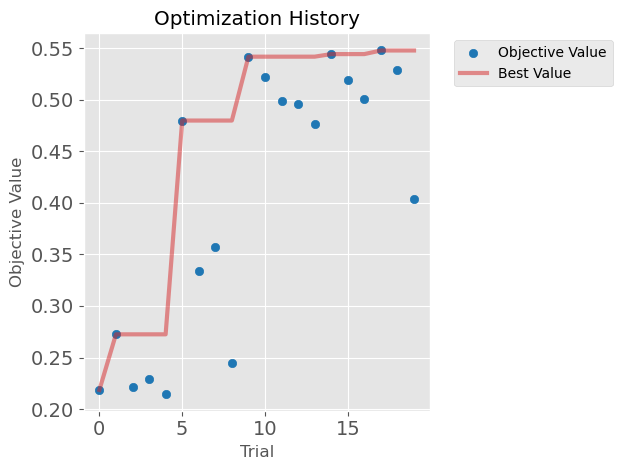

/tmp/ipykernel_917786/3970159883.py:7: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


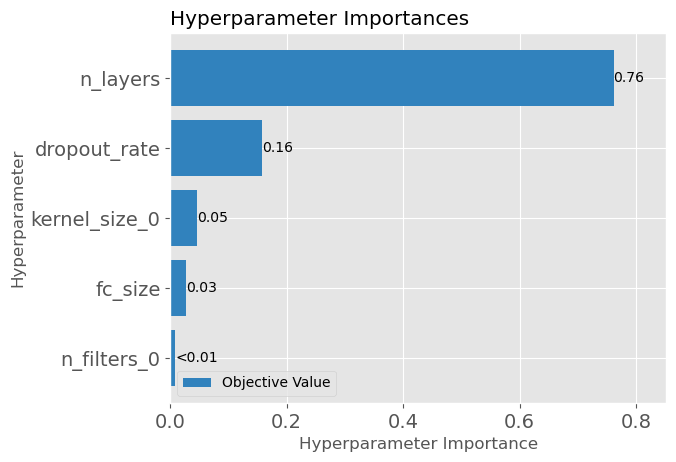

/tmp/ipykernel_917786/3970159883.py:10: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_parallel_coordinate(


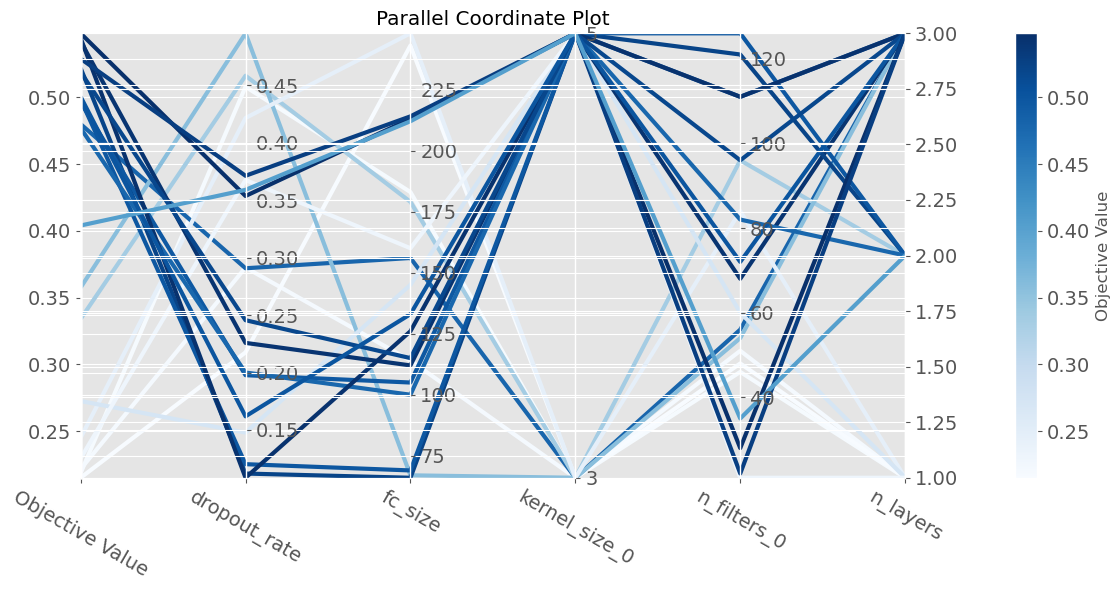

In [8]:
# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

# Importance of hyperparameters
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

ax = optuna.visualization.matplotlib.plot_parallel_coordinate(
    study, params=['n_layers', 'n_filters_0', 'kernel_size_0', 'dropout_rate', 'fc_size']
)
fig = ax.figure
fig.set_size_inches(12, 6, forward=True)  # forward=True updates the canvas
fig.tight_layout()

In [9]:
class FlexibleSimpleCNN(nn.Module):
    """
    A simple, flexible Convolutional Neural Network.

    This network consists of two convolutional layers, each followed by a
    max-pooling layer, and two fully connected layers. The number of filters
    in the convolutional layers and the size of the hidden linear layer are
    configurable, making the architecture adaptable to different requirements.
    """
    def __init__(self, conv1_out, conv2_out, fc_size, num_classes):
        """
        Initializes the layers of the CNN.

        Args:
            conv1_out: The number of output channels for the first
                       convolutional layer.
            conv2_out: The number of output channels for the second
                       convolutional layer.
            fc_size: The number of neurons in the hidden fully connected layer.
            num_classes: The number of output classes for the final layer.
        """
        super(FlexibleSimpleCNN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=3, padding=1)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        # Define a max pooling layer to be used after each convolution
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define the first fully connected (hidden) layer
        # Assumes input images are 32x32, resulting in an 8x8 feature map after two pooling layers
        self.fc1 = nn.Linear(conv2_out * 8 * 8, fc_size)
        # Define the final fully connected (output) layer
        self.fc2 = nn.Linear(fc_size, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x: The input tensor of shape (batch_size, channels, height, width).

        Returns:
            The output logits from the network.
        """
        # Apply the first convolutional block: convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply the second convolutional block
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature map to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        # Pass through the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Pass through the final output layer
        x = self.fc2(x)
        # Return the resulting logits
        return x

In [10]:
%%bash

if [ -e "/tmp/apple_ad_subset.zip" ]; then
    echo "apple_ad_subset.zip already exists!"
else
    gdown 1SpJcrOW5Ie8npYneptzeBS1wYzkSSdwn -O /tmp/
fi

unzip -qn /tmp/apple_ad_subset.zip -d /tmp

Downloading...
From (original): https://drive.google.com/uc?id=1SpJcrOW5Ie8npYneptzeBS1wYzkSSdwn
From (redirected): https://drive.google.com/uc?id=1SpJcrOW5Ie8npYneptzeBS1wYzkSSdwn&confirm=t&uuid=bd432486-eeb7-4a41-9868-bafad3f7fe04
To: /tmp/apple_ad_subset.zip
100%|██████████| 169M/169M [00:17<00:00, 9.95MB/s] 


In [11]:
def objective_apples(trial, device):
    """
    Defines the Optuna objective function for a CNN on an apple dataset.

    For each trial, this function samples hyperparameters for a CNN
    architecture, trains the model on a custom apple dataset, and evaluates
    its performance. It logs accuracy, precision, and recall, while
    returning the F1-score as the primary metric for Optuna to optimize.

    Args:
        trial: An Optuna `Trial` object used to sample hyperparameters.
        device: The device ('cpu' or 'cuda') for model training and evaluation.

    Returns:
        The F1-score of the trained model on the validation set.
    """
    # Sample a set of hyperparameters for the model architecture
    conv1_out = trial.suggest_int("conv1_out", 8, 64, step=8)
    conv2_out = trial.suggest_int("conv2_out", 16, 128, step=16)
    fc_size = trial.suggest_int("fc_size", 32, 256, step=32)

    # Define fixed parameters for the data loaders
    img_size = 32
    batch_size = 128

    # Create the training and validation data loaders for the apple dataset
    train_loader, val_loader = helper_utils.get_apples_dataset_dataloaders(
        img_size=img_size,
        batch_size=batch_size
    )

    # Specify the number of output classes for the dataset
    num_classes = 2
    # Create an instance of the model with the sampled hyperparameters
    model = FlexibleSimpleCNN(
        conv1_out=conv1_out,
        conv2_out=conv2_out,
        fc_size=fc_size,
        num_classes=num_classes
    ).to(device)
    
    # Define fixed training components: learning rate, optimizer, and loss function
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fcn = nn.CrossEntropyLoss()

    # Set the fixed number of epochs for the training loop
    n_epochs = 5
    # Train the model using a helper function
    helper_utils.train_model(
        model=model,
        optimizer=optimizer,
        train_dataloader=train_loader,
        n_epochs=n_epochs,
        loss_fcn=loss_fcn,
        device=device
    )

    # Evaluate the trained model on the validation set to get performance metrics
    accuracy, precision, recall, f1 = helper_utils.evaluate_metrics(
        model, val_loader, device, num_classes=2
    )

    # Log additional metrics to the Optuna trial for more detailed analysis
    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)

    # Return the F1-score as the objective value for Optuna to maximize
    return f1

In [12]:
seed = 42
helper_utils.set_seed(seed)

sampler = optuna.samplers.TPESampler(seed=seed)  # Use TPE sampler (the default sampler in Optuna)

# Create a study object and optimize the objective function
study_apples = optuna.create_study(direction='maximize', sampler=sampler)

n_trials = 10
study_apples.optimize(lambda trial: objective_apples(trial, device), n_trials=n_trials)  

[I 2025-12-03 22:12:36,376] A new study created in memory with name: no-name-a20f2a7b-fde6-4418-b6f2-a7e8bc0abaa3


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3548
Training complete!



[I 2025-12-03 22:13:00,514] Trial 0 finished with value: 0.6255446672439575 and parameters: {'conv1_out': 24, 'conv2_out': 128, 'fc_size': 192}. Best is trial 0 with value: 0.6255446672439575.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.4515
Training complete!



[I 2025-12-03 22:13:24,700] Trial 1 finished with value: 0.439461886882782 and parameters: {'conv1_out': 40, 'conv2_out': 32, 'fc_size': 64}. Best is trial 0 with value: 0.6255446672439575.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3359
Training complete!



[I 2025-12-03 22:13:49,353] Trial 2 finished with value: 0.7176079750061035 and parameters: {'conv1_out': 8, 'conv2_out': 112, 'fc_size': 160}. Best is trial 2 with value: 0.7176079750061035.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3461
Training complete!



[I 2025-12-03 22:14:13,243] Trial 3 finished with value: 0.6919227838516235 and parameters: {'conv1_out': 48, 'conv2_out': 16, 'fc_size': 256}. Best is trial 2 with value: 0.7176079750061035.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3534
Training complete!



[I 2025-12-03 22:14:37,576] Trial 4 finished with value: 0.8412935733795166 and parameters: {'conv1_out': 56, 'conv2_out': 32, 'fc_size': 64}. Best is trial 4 with value: 0.8412935733795166.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3715
Training complete!



[I 2025-12-03 22:15:02,048] Trial 5 finished with value: 0.5040310621261597 and parameters: {'conv1_out': 16, 'conv2_out': 48, 'fc_size': 160}. Best is trial 4 with value: 0.8412935733795166.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2958
Training complete!



[I 2025-12-03 22:15:25,955] Trial 6 finished with value: 0.7342193126678467 and parameters: {'conv1_out': 32, 'conv2_out': 48, 'fc_size': 160}. Best is trial 4 with value: 0.8412935733795166.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2837
Training complete!



[I 2025-12-03 22:15:48,675] Trial 7 finished with value: 0.858942985534668 and parameters: {'conv1_out': 16, 'conv2_out': 48, 'fc_size': 96}. Best is trial 7 with value: 0.858942985534668.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3141
Training complete!



[I 2025-12-03 22:16:12,542] Trial 8 finished with value: 0.9125000238418579 and parameters: {'conv1_out': 32, 'conv2_out': 112, 'fc_size': 64}. Best is trial 8 with value: 0.9125000238418579.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3694
Training complete!



[I 2025-12-03 22:16:35,918] Trial 9 finished with value: 0.677465558052063 and parameters: {'conv1_out': 40, 'conv2_out': 80, 'fc_size': 32}. Best is trial 8 with value: 0.9125000238418579.


In [13]:
df_apples_study = study_apples.trials_dataframe()

df_apples_study

,number,value,datetime_start,datetime_complete,duration,params_conv1_out,params_conv2_out,params_fc_size,user_attrs_accuracy,user_attrs_precision,user_attrs_recall,state
0,0,0.625545,2025-12-03 22:12:36.377464,2025-12-03 22:13:00.514271,0 days 00:00:24.136807,24,128,192,0.824,0.839588,0.606009,COMPLETE
1,1,0.439462,2025-12-03 22:13:00.514809,2025-12-03 22:13:24.700843,0 days 00:00:24.186034,40,32,64,0.784,0.392000,0.500000,COMPLETE
2,2,0.717608,2025-12-03 22:13:24.701397,2025-12-03 22:13:49.353874,0 days 00:00:24.652477,8,112,160,0.864,0.860886,0.676211,COMPLETE
3,3,0.691923,2025-12-03 22:13:49.354359,2025-12-03 22:14:13.243441,0 days 00:00:23.889082,48,16,256,0.868,0.807815,0.654647,COMPLETE
4,4,0.841294,2025-12-03 22:14:13.243873,2025-12-03 22:14:37.576225,0 days 00:00:24.332352,56,32,64,0.932,0.925148,0.792602,COMPLETE
5,5,0.504031,2025-12-03 22:14:37.576777,2025-12-03 22:15:02.048173,0 days 00:00:24.471396,16,48,160,0.812,0.904858,0.530000,COMPLETE
6,6,0.734219,2025-12-03 22:15:02.048628,2025-12-03 22:15:25.954951,0 days 00:00:23.906323,32,48,160,0.872,0.930736,0.686275,COMPLETE
7,7,0.858943,2025-12-03 22:15:25.955412,2025-12-03 22:15:48.675223,0 days 00:00:22.719811,16,48,96,0.916,0.899405,0.830574,COMPLETE
8,8,0.912500,2025-12-03 22:15:48.675662,2025-12-03 22:16:12.542327,0 days 00:00:23.866665,32,112,64,0.944,0.912500,0.912500,COMPLETE
9,9,0.677466,2025-12-03 22:16:12.542768,2025-12-03 22:16:35.918056,0 days 00:00:23.375288,40,80,32,0.856,0.840949,0.641547,COMPLETE


In [14]:
# Run with Grid Search Sampler

# Define the hyperparameter grid
param_grid = {
    "conv1_out": list(range(8, 65, 8)),       # [8, 16, 24, 32, 40, 48, 56, 64]
    "conv2_out": list(range(16, 129, 16)),    # [16, 32, 48, 64, 80, 96, 112, 128]
    "fc_size":   list(range(32, 257, 32))     # [32, 64, 96, 128, 160, 192, 224, 256]
}

# Create a GridSampler with the defined grid
grid_sampler = optuna.samplers.GridSampler(param_grid, seed=seed)  # Use seed for reproducibility

# Create a study object with the GridSampler
study_grid = optuna.create_study(direction='maximize', sampler=grid_sampler)

study_grid.optimize(lambda trial: objective_apples(trial, device), n_trials=n_trials)

[I 2025-12-03 22:16:35,962] A new study created in memory with name: no-name-6a09373a-77d7-415d-8bc8-aa778f55fdf0


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3343
Training complete!



[I 2025-12-03 22:16:59,758] Trial 0 finished with value: 0.4343891441822052 and parameters: {'conv1_out': 40, 'conv2_out': 112, 'fc_size': 32}. Best is trial 0 with value: 0.4343891441822052.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3425
Training complete!



[I 2025-12-03 22:17:22,174] Trial 1 finished with value: 0.44933921098709106 and parameters: {'conv1_out': 64, 'conv2_out': 96, 'fc_size': 256}. Best is trial 1 with value: 0.44933921098709106.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2647
Training complete!



[I 2025-12-03 22:17:45,468] Trial 2 finished with value: 0.8049752712249756 and parameters: {'conv1_out': 56, 'conv2_out': 112, 'fc_size': 256}. Best is trial 2 with value: 0.8049752712249756.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2778
Training complete!



[I 2025-12-03 22:18:09,966] Trial 3 finished with value: 0.8275692462921143 and parameters: {'conv1_out': 24, 'conv2_out': 64, 'fc_size': 64}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3035
Training complete!



[I 2025-12-03 22:18:34,016] Trial 4 finished with value: 0.8207193613052368 and parameters: {'conv1_out': 64, 'conv2_out': 112, 'fc_size': 64}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.4426
Training complete!



[I 2025-12-03 22:18:57,484] Trial 5 finished with value: 0.45652174949645996 and parameters: {'conv1_out': 24, 'conv2_out': 16, 'fc_size': 128}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3235
Training complete!



[I 2025-12-03 22:19:21,623] Trial 6 finished with value: 0.7238179445266724 and parameters: {'conv1_out': 32, 'conv2_out': 32, 'fc_size': 160}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2880
Training complete!



[I 2025-12-03 22:19:45,414] Trial 7 finished with value: 0.691718578338623 and parameters: {'conv1_out': 64, 'conv2_out': 128, 'fc_size': 96}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3742
Training complete!



[I 2025-12-03 22:20:09,599] Trial 8 finished with value: 0.5978121161460876 and parameters: {'conv1_out': 48, 'conv2_out': 16, 'fc_size': 192}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2829
Training complete!



[I 2025-12-03 22:20:33,128] Trial 9 finished with value: 0.7767857313156128 and parameters: {'conv1_out': 32, 'conv2_out': 112, 'fc_size': 256}. Best is trial 3 with value: 0.8275692462921143.


/tmp/ipykernel_917786/2658579028.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_apples)


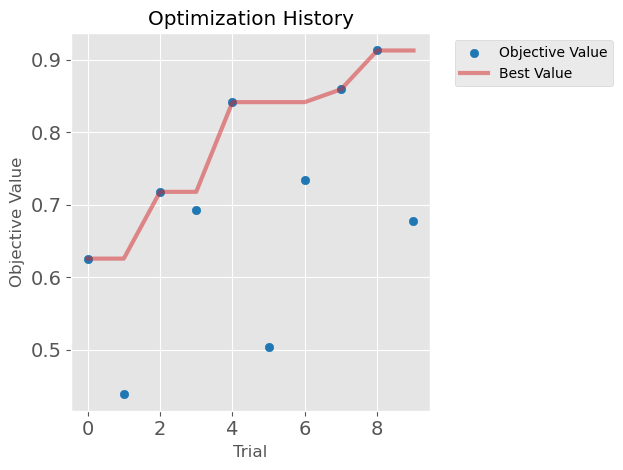

/tmp/ipykernel_917786/2658579028.py:7: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_grid)


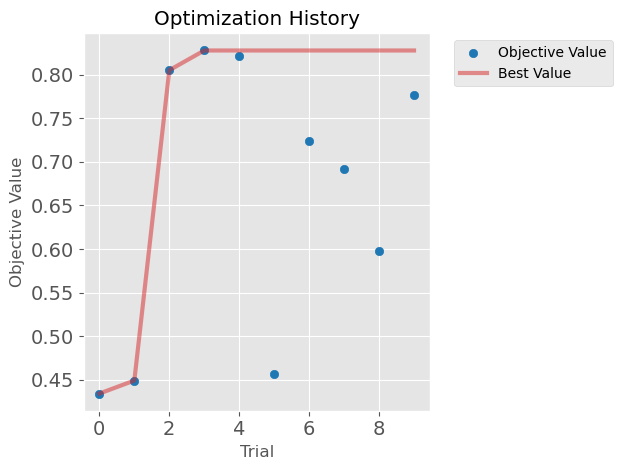

In [15]:
# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_apples)
plt.title('Optimization History')
plt.show()

# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_grid)
plt.title('Optimization History')
plt.show()